In [1]:
# !pip install torch
# !pip install torchvision

In [2]:
import os
import xml.etree.ElementTree as ET
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
from torchvision.ops import nms
from sklearn.metrics import precision_recall_curve, auc
import copy
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:

# set direction and set parameters
data_dir = './Data/'
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'xmls')
use_subset = False
sub_percentage = 0.1
train_batch_size = 30
test_batch_size = 1
step_size = 5
gamma = 0.5
lr = 0.005
weight_decay= 0.001
num_epochs = 30
nms_iou_thresh = 0.4
mAP_iou_threshold= 0.5
score_thresh = 0.2
num_classes = 5
local_model_path = './faster_rcnn_model.pth'
patience = 5
num_worker = os.cpu_count()

In [4]:

# dataset class
class RDD2022Dataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.classes = ['Background', 'D00', 'D10', 'D20', 'D40']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        print(self.class_to_idx)

        self.images = list(sorted(os.listdir(image_dir)))
        self.labels = list(sorted(os.listdir(label_dir)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # load image and label
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        label_path = os.path.join(self.label_dir, self.labels[idx])
        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.iter('object'):
            cls = obj.findtext('name')
            labels.append(self.class_to_idx[cls])
            xmlbox = obj.find('bndbox')
            bbox_coords = ['xmin', 'ymin', 'xmax', 'ymax']
            boxes.append([int(float(xmlbox.findtext(tag))) for tag in bbox_coords])
        # if have label
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # if it doesn't have label
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            area = torch.zeros(0, dtype=torch.float32)

        image_id = torch.tensor([idx])
        iscrowd = torch.zeros(len(boxes), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target


In [5]:

def get_transform():
    def transform(img, target):
        img = F.to_tensor(img)
        return img, target
    return transform

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Create dataset and data loader
train_dataset = RDD2022Dataset(
    os.path.join(image_dir, 'train'),
    os.path.join(label_dir, 'train'),
    transforms=get_transform()
)

val_dataset = RDD2022Dataset(
    os.path.join(image_dir, 'val'),
    os.path.join(label_dir, 'val'),
    transforms=get_transform()
)

def create_subset(dataset, subset_size):
    # Check subset condition
    if isinstance(subset_size, float) and subset_size > 0 and subset_size < 1:
        subset_size = int(len(dataset) * subset_size)
    elif isinstance(subset_size, int) and subset_size > 0 and subset_size < len(dataset):
        subset_size = subset_size
    else:
        raise ValueError("subset_size must be a positive integer or a float between 0 and 1.")
    # Generate a random subset
    indices = torch.randperm(len(dataset))[:subset_size]
    subset = Subset(dataset, indices)
    return subset

# DataLoader setup
# if using subset
if use_subset:
    train_subset_size = sub_percentage
    val_subset_size = sub_percentage
    train_subset = create_subset(train_dataset, train_subset_size)
    val_subset = create_subset(val_dataset, val_subset_size)
    train_loader = DataLoader(train_subset, batch_size=train_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_subset, batch_size=train_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    print('Using subset')
# if using full dataset
else:
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    print('Using full dataset')

# Clear CUDA cache
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()


{'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}
{'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}
Using full dataset


In [6]:

# calculate Intersection over Union (IoU)
def calculate_iou(gt_box, pred_box):
    xi1 = max(gt_box[0], pred_box[0])
    yi1 = max(gt_box[1], pred_box[1])
    xi2 = min(gt_box[2], pred_box[2])
    yi2 = min(gt_box[3], pred_box[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    union_area = gt_area + pred_area - inter_area

    if union_area == 0:
        return 0
    iou = inter_area / union_area
    return iou

# apply Non-Max Suppression (NMS) to filter predictions
def apply_nms(orig_prediction, iou_thresh=nms_iou_thresh, score_thresh=score_thresh):
    # if no detections to process
    if orig_prediction['scores'].nelement() == 0:
        return {
            'boxes': torch.empty((0, 4), dtype=torch.float32),
            'scores': torch.empty((0,), dtype=torch.float32),
            'labels': torch.empty((0,), dtype=torch.int64)
        }
    # apply NMS
    boxes = orig_prediction['boxes'].float()
    scores = orig_prediction['scores'].float()
    high_score_mask = scores > score_thresh
    boxes = boxes[high_score_mask]
    scores = scores[high_score_mask]
    labels = orig_prediction['labels'][high_score_mask]
    keep = nms(boxes, scores, iou_thresh)
    return {'boxes': boxes[keep], 'scores': scores[keep],'labels': labels[keep]}

# update true positives, false positives, and false negatives for each class
def compute_tp_fp_fn_for_image(epoch_index, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, num_classes, iou_threshold= mAP_iou_threshold):
    # iterate through each class (ignoring the background class)
    for cls in range(1, num_classes):
        # filter ground truth and predictions for the current class
        gt_idx = np.where(gt_labels == cls)[0]
        pred_idx = np.where(pred_labels == cls)[0]

        if len(gt_idx) == 0 and len(pred_idx) == 0:
            continue
        elif len(gt_idx) == 0:
            epoch_index[cls-1,1] += len(pred_boxes[pred_idx])
            continue
        elif len(pred_idx) == 0:
            epoch_index[cls-1,2] += len(gt_boxes[gt_idx])
            continue

        class_gt_boxes = gt_boxes[gt_idx]
        class_pred_boxes = pred_boxes[pred_idx]
        class_pred_scores = pred_scores[pred_idx]

        # sort predictions by scores in descending order
        sorted_indices = np.argsort(-class_pred_scores)
        class_pred_boxes = class_pred_boxes[sorted_indices]

        # initialize counters for true positives, false positives, and false negatives
        tp = 0
        detected = np.zeros(len(class_gt_boxes), dtype=bool)

        # check each predicted box against all GT boxes of the same class
        for pred_box in class_pred_boxes:
            ious = [calculate_iou(pred_box, gt_box) for gt_box in class_gt_boxes]
            max_iou = max(ious)
            max_gt_idx = np.argmax(ious)

            if max_iou >= iou_threshold and not detected[max_gt_idx]:
                tp += 1
                detected[max_gt_idx] = True

        # update class metrics
        epoch_index[cls-1,0] += tp
        epoch_index[cls-1,1] += (len(class_pred_boxes) - tp)  # All non-TPs are FPs
        epoch_index[cls-1,2] += (len(class_gt_boxes) - np.sum(detected))  # GTs not detected are FNs

    return epoch_index


In [7]:

# evaluate the model and calculate mAP along with precision, recall, and F1 scores
def evaluate_or_test_model(model, data_loader, device):
    model.eval()
    # total_val_loss = 0
    epoch_index = np.zeros((num_classes-1, 3))
    all_detections = [[] for _ in range(num_classes-1)]
    all_annotations = [[] for _ in range(num_classes-1)]

    with torch.no_grad():
        # for each evaluation batch
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            for i, output in enumerate(outputs):
                nms_output = apply_nms(output)
                pred_boxes = nms_output['boxes'].cpu().numpy()
                pred_labels = nms_output['labels'].cpu().numpy()
                pred_scores = nms_output['scores'].cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()
                epoch_index = compute_tp_fp_fn_for_image(epoch_index, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, num_classes)

                # Store detections and annotations for mAP calculation
                for label in range(1, num_classes):
                    pred_indices = np.where(pred_labels == label)[0]
                    gt_indices = np.where(gt_labels == label)[0]
                    all_detections[label-1].extend([(box, score) for box, score in zip(pred_boxes[pred_indices], pred_scores[pred_indices])])
                    all_annotations[label-1].extend(gt_boxes[gt_indices])

            # Compute losses
            # if targets:
            #     model.train()
            #     loss_dict = model(images, targets)
            #     losses = sum(loss for loss in loss_dict.values())
            #     total_val_loss += losses.item()
            #     model.eval()

            del images, targets, outputs
            clear_memory()

    # avg_loss = total_val_loss / len(data_loader)

    # calculate mAP for each class
    avg_precisions = []
    for class_detections, class_annotations in zip(all_detections, all_annotations):
        if not class_detections or not class_annotations:
            continue
        # sort detections by decreasing confidence
        sorted_detections = sorted(class_detections, key=lambda x: x[1], reverse=True)
        tp = np.zeros(len(sorted_detections))
        fp = np.zeros(len(sorted_detections))
        matched = np.zeros(len(class_annotations), dtype=bool)  # Tracks which GT boxes have been matched

        for d_idx, (bbox, score) in enumerate(sorted_detections):
            ious = [calculate_iou(bbox, gt_bbox) for gt_bbox in class_annotations]
            best_iou = max(ious) if ious else 0
            best_idx = np.argmax(ious) if ious else -1

            if best_iou >= mAP_iou_threshold:
                if not matched[best_idx]:
                    tp[d_idx] = 1
                    matched[best_idx] = True
                else:
                    fp[d_idx] = 1
            else:
                fp[d_idx] = 1

        # accumulate true positives and false positives for precision-recall calculation
        acc_tp = np.cumsum(tp)
        acc_fp = np.cumsum(fp)
        recall = acc_tp / len(class_annotations) if len(class_annotations) > 0 else np.zeros_like(acc_tp)
        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp).any() else np.zeros_like(acc_tp)

        # calculate area under the precision-recall curve (AUC)
        ap = auc(recall, precision)
        avg_precisions.append(ap)

    # compute the mean of average precisions across all classes
    mAP50 = np.mean(avg_precisions) if avg_precisions else 0

    # calculate overall precision, recall, and F1 score
    tp_total = epoch_index[:, 0]
    fp_total = epoch_index[:, 1]
    fn_total = epoch_index[:, 2]
    recall = tp_total / (tp_total + fn_total + 1e-6)
    precision = tp_total / (tp_total + fp_total + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    # return avg_loss, mean_ap, precision, recall, f1_score

    return mAP50, precision, recall, f1_score


In [8]:

# train the model
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, patience=patience):
    best_mAP50 = 0
    last_mAP50 = 0
    best_model_wts = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        total_train_loss = 0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            model.train()
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_train_loss += losses.item()
            losses.backward()
            optimizer.step()
            del images, targets, loss_dict
            clear_memory()
        mAP50, precision, recall, f1_score = evaluate_or_test_model(model, val_loader, device)
        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss/len(train_loader):.4f}, '
        #       f'Val Loss: {val_loss:.4f}, mAP: {mean_ap:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss/len(train_loader):.4f}, mAP50: {mAP50:.4f}')
        print(f'F1 per group: {f1_score}, Recall per group: {recall}, Precision per group: {precision}')
        print(f'General F1: {sum(f1_score) / len(f1_score)}, General Recall: {sum(recall) / len(recall)}, General Precision: {sum(precision) / len(precision)}')
        lr_scheduler.step()


        if mAP50 >= best_mAP50:
            best_mAP50 = mAP50
            last_mAP50 = mAP50
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        elif mAP50 >= last_mAP50:
            last_mAP50 = mAP50
            epochs_no_improve -= 1
        else:
            last_mAP50 = mAP50
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break
        clear_memory()

    model.load_state_dict(best_model_wts)
    return model, best_mAP50

# Initialize and train the model
model = get_model(len(train_dataset.classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
trained_model, best_mAP50 = train_model(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs)


Epoch 1/30, Train Loss: 0.3767, mAP50: 0.4482
F1 per group: [0.350334   0.36994567 0.32859039 0.21426625], Recall per group: [0.65512885 0.6096613  0.61083123 0.41255144], Precision per group: [0.23909636 0.26553809 0.22474513 0.1447131 ]
General F1: 0.31578407691432414, General Recall: 0.5720432063768098, General Precision: 0.2185231703514113


Epoch 2/30, Train Loss: 0.3349, mAP50: 0.4918
F1 per group: [0.35880621 0.34811866 0.44764471 0.28857188], Recall per group: [0.69277413 0.68850638 0.61649874 0.48971193], Precision per group: [0.24209783 0.23295134 0.35139986 0.20455522]
General F1: 0.36078536494963426, General Recall: 0.6218727967375743, General Precision: 0.2577510621736665


Epoch 3/30, Train Loss: 0.3235, mAP50: 0.4971
F1 per group: [0.42435561 0.3281147  0.41553199 0.33158768], Recall per group: [0.65765538 0.71571349 0.65365239 0.48868313], Precision per group: [0.31323706 0.21284676 0.30457746 0.25092446]
General F1: 0.3748974976268599, General Recall: 0.6289260982627896, General Precision: 0.27039643758606724


Epoch 4/30, Train Loss: 0.3155, mAP50: 0.5351
F1 per group: [0.34369629 0.37555847 0.36041463 0.21649827], Recall per group: [0.7122284  0.69961133 0.71095718 0.61831276], Precision per group: [0.22649847 0.25667142 0.24139406 0.13122271]
General F1: 0.32404191582168956, General Recall: 0.6852774149030385, General Precision: 0.21394666413446645


Epoch 5/30, Train Loss: 0.3077, mAP50: 0.5317
F1 per group: [0.42474848 0.34048605 0.53577143 0.31170203], Recall per group: [0.69984841 0.72681843 0.62720403 0.59053498], Precision per group: [0.30489818 0.22231658 0.46760563 0.21172999]
General F1: 0.40317699838095555, General Recall: 0.6611014626394773, General Precision: 0.3016375955685693


Epoch 6/30, Train Loss: 0.2928, mAP50: 0.5340
F1 per group: [0.43204068 0.42005603 0.51646399 0.35188021], Recall per group: [0.70111167 0.70238756 0.65680101 0.58230453], Precision per group: [0.31221872 0.29962103 0.4255406  0.25211581]
General F1: 0.430110228241544, General Recall: 0.6606511919382563, General Precision: 0.3223740406897331


Epoch 7/30, Train Loss: 0.2874, mAP50: 0.5478
F1 per group: [0.42100524 0.37980521 0.50452495 0.29508969], Recall per group: [0.71500758 0.72681843 0.68450882 0.61522634], Precision per group: [0.29833439 0.25706991 0.39948548 0.19409283]
General F1: 0.4001062723886015, General Recall: 0.6853902914275309, General Precision: 0.28724565277476793


Epoch 8/30, Train Loss: 0.2827, mAP50: 0.5356
F1 per group: [0.46612283 0.46599954 0.4765935  0.32119526], Recall per group: [0.69353209 0.64686285 0.70843829 0.60802469], Precision per group: [0.35102302 0.3641763  0.35908075 0.21824225]
General F1: 0.4324777829634715, General Recall: 0.6642144794470561, General Precision: 0.3231305802788142


Epoch 9/30, Train Loss: 0.2775, mAP50: 0.5460
F1 per group: [0.42553476 0.38390697 0.49031089 0.37987198], Recall per group: [0.70060637 0.71793448 0.70906801 0.55144033], Precision per group: [0.30556474 0.26200608 0.37470882 0.28972973]
General F1: 0.41990614955888955, General Recall: 0.6697622963500279, General Precision: 0.3080023413291588


Epoch 10/30, Train Loss: 0.2711, mAP50: 0.5301
F1 per group: [0.44532342 0.43479728 0.50358335 0.41639296], Recall per group: [0.69656392 0.69516935 0.68576826 0.52263374], Precision per group: [0.3272792  0.31632137 0.39788089 0.34604905]
General F1: 0.45002425328562895, General Recall: 0.6500338192056024, General Precision: 0.3468826285048548


Epoch 11/30, Train Loss: 0.2591, mAP50: 0.5497
F1 per group: [0.44671821 0.39969072 0.47937003 0.37278867], Recall per group: [0.69479535 0.71848973 0.70969773 0.56378601], Precision per group: [0.32918362 0.27685066 0.36191394 0.27845528]
General F1: 0.42464190900843435, General Recall: 0.6716922046857273, General Precision: 0.3116008772773453


Epoch 12/30, Train Loss: 0.2537, mAP50: 0.5455
F1 per group: [0.49105615 0.4538513  0.48501787 0.339705  ], Recall per group: [0.67281455 0.69350361 0.70843829 0.55761317], Precision per group: [0.3866144  0.33729409 0.36873156 0.24425417]
General F1: 0.44240758023462295, General Recall: 0.6580924040533951, General Precision: 0.3342235548306734


Epoch 13/30, Train Loss: 0.2490, mAP50: 0.5285
F1 per group: [0.50873358 0.46153801 0.52738683 0.36899818], Recall per group: [0.6548762  0.67795669 0.68513854 0.55349794], Precision per group: [0.41591784 0.34985673 0.428684   0.27674897]
General F1: 0.46666414999262756, General Recall: 0.642867342678827, General Precision: 0.367801887695142


Epoch 14/30, Train Loss: 0.2445, mAP50: 0.5499
F1 per group: [0.42998957 0.4076651  0.49364996 0.31201295], Recall per group: [0.70565942 0.714603   0.6731738  0.57716049], Precision per group: [0.3091996  0.28517616 0.38971929 0.21379573]
General F1: 0.4108293956637311, General Recall: 0.6676491795116476, General Precision: 0.2994726940169965


Epoch 15/30, Train Loss: 0.2396, mAP50: 0.5382
F1 per group: [0.43631393 0.38865168 0.51808108 0.33832935], Recall per group: [0.69151086 0.73403665 0.63602015 0.56893004], Precision per group: [0.31870051 0.26429428 0.43704024 0.2407488 ]
General F1: 0.42034400742806893, General Recall: 0.657624425274504, General Precision: 0.3151959598379009


Epoch 16/30, Train Loss: 0.2295, mAP50: 0.5344
F1 per group: [0.47761417 0.45045328 0.52150621 0.37389726], Recall per group: [0.66978272 0.68906163 0.67569269 0.54526749], Precision per group: [0.37113258 0.33459153 0.42461417 0.28448739]
General F1: 0.4558677289228032, General Recall: 0.6449511335897232, General Precision: 0.35370641598121944


Epoch 17/30, Train Loss: 0.2258, mAP50: 0.5377
F1 per group: [0.48222379 0.4299251  0.50591189 0.38780711], Recall per group: [0.6682668  0.7051638  0.68702771 0.54320988], Precision per group: [0.3772105  0.30922815 0.40036697 0.30154198]
General F1: 0.45146697141969777, General Recall: 0.6509170455262041, General Precision: 0.3470868978501509


Epoch 18/30, Train Loss: 0.2223, mAP50: 0.5429
F1 per group: [0.45275546 0.42187458 0.48850907 0.37063139], Recall per group: [0.6682668  0.68961688 0.70277078 0.54012346], Precision per group: [0.3423505  0.30389038 0.37437102 0.28210639]
General F1: 0.4334426219051458, General Recall: 0.6501944792557011, General Precision: 0.325679574846769


Epoch 19/30, Train Loss: 0.2193, mAP50: 0.5395
F1 per group: [0.47718099 0.43126362 0.50746221 0.3656865 ], Recall per group: [0.66043456 0.69239311 0.66372796 0.55041152], Precision per group: [0.3735353  0.31315922 0.41075604 0.27379734]
General F1: 0.44539833175116067, General Recall: 0.641741789660661, General Precision: 0.3428119727907358


Epoch 20/30, Train Loss: 0.2161, mAP50: 0.5381
F1 per group: [0.47005399 0.43106686 0.5020685  0.35811893], Recall per group: [0.65437089 0.69183787 0.68765743 0.55246914], Precision per group: [0.36675163 0.31306533 0.39536568 0.26492353]
General F1: 0.4403270706991205, General Recall: 0.6465838318060902, General Precision: 0.33502654100549645


Epoch 21/30, Train Loss: 0.2090, mAP50: 0.5380
F1 per group: [0.48902053 0.4207212  0.53255293 0.38273875], Recall per group: [0.64426478 0.70571904 0.6593199  0.52469136], Precision per group: [0.39406583 0.29969347 0.44667235 0.3012404 ]
General F1: 0.45625834982618196, General Recall: 0.6334987702316088, General Precision: 0.3604180141996275


Epoch 22/30, Train Loss: 0.2064, mAP50: 0.5323
F1 per group: [0.47649843 0.43756589 0.51245164 0.38112881], Recall per group: [0.6505811  0.68684064 0.67380353 0.52777778], Precision per group: [0.37591241 0.32104853 0.41344668 0.29825581]
General F1: 0.45191119044917416, General Recall: 0.6347507620915446, General Precision: 0.3521658582055146


Epoch 23/30, Train Loss: 0.2048, mAP50: 0.5305
F1 per group: [0.48760363 0.43366676 0.52460559 0.37605536], Recall per group: [0.64350682 0.6851749  0.6813602  0.52674897], Precision per group: [0.3925104  0.31722365 0.42648798 0.29240434]
General F1: 0.45548283385137006, General Recall: 0.6341977239123948, General Precision: 0.35715659260780497
Early stopping triggered


In [11]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")
save_model_path = f'./faster_rcnn_lr{lr}_bs{train_batch_size}_epochs{num_epochs}_mAP{best_mAP50}_stable.pth'
# Example usage:
model_save_path = save_model_path
save_model(trained_model, model_save_path)


Model saved to ./faster_rcnn_lr0.005_bs30_epochs30_mAP0.5498564142244129_stable.pth


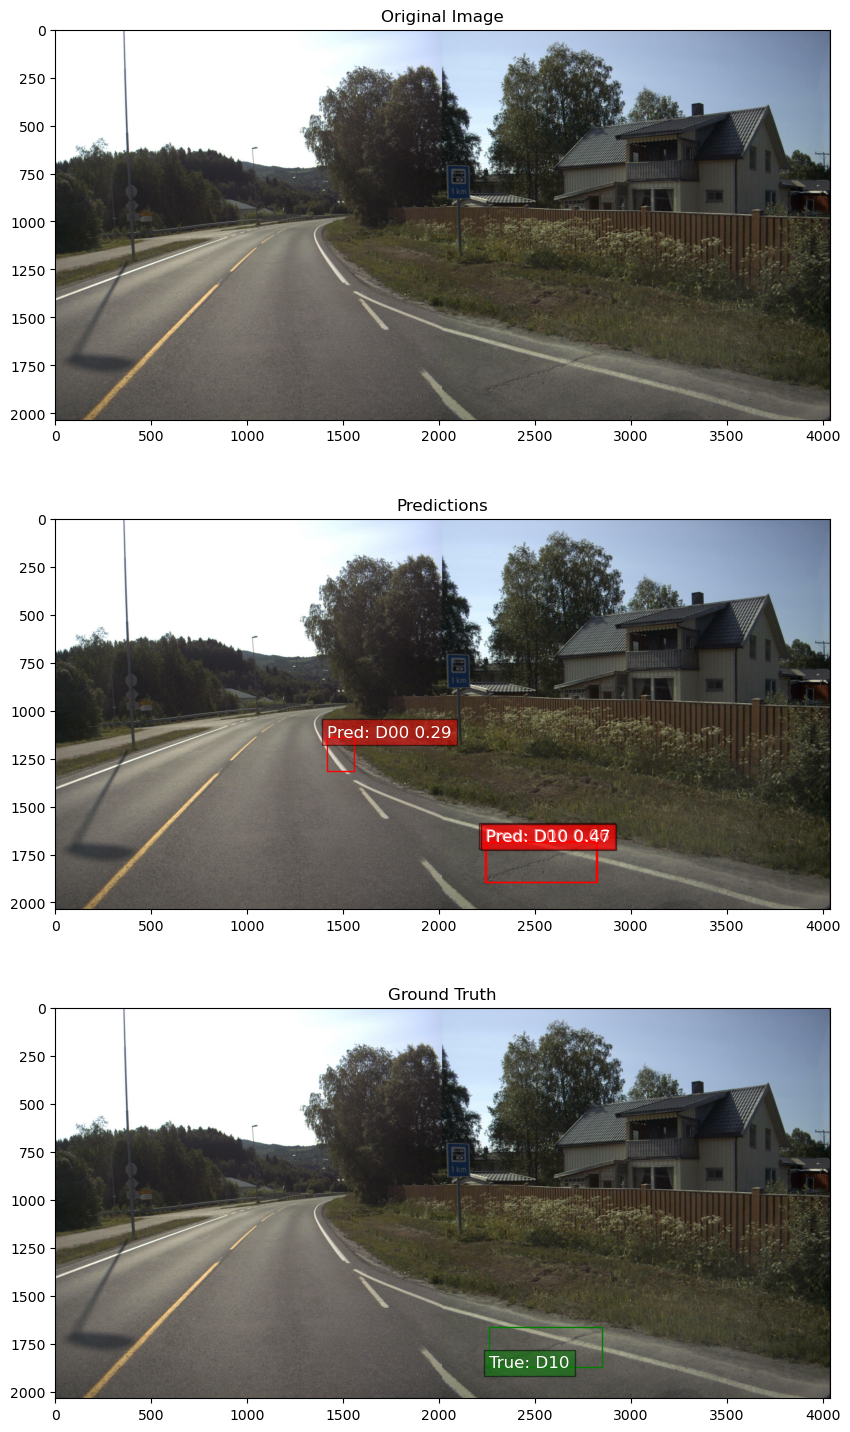

In [12]:
def visualize_comparison_three_plots(image_path, label_path, model, device, dataset_classes, transform=None):
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    if transform:
        image_tensor, _ = transform(image, {})  # Assuming the transform function returns a tensor and a target
    else:
        image_tensor = F.to_tensor(image)  # Convert to tensor without any additional transformation

    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and transfer to device

    # Load true labels and boxes
    tree = ET.parse(label_path)
    root = tree.getroot()
    true_boxes = []
    true_labels = []
    for obj in root.iter('object'):
        cls = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(float(xmlbox.find('xmin').text))
        ymin = int(float(xmlbox.find('ymin').text))
        xmax = int(float(xmlbox.find('xmax').text))
        ymax = int(float(xmlbox.find('ymax').text))
        true_boxes.append([xmin, ymin, xmax, ymax])
        true_labels.append(dataset_classes.index(cls))

    # Model inference
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    predictions = apply_nms(predictions[0], 30)  # Assuming apply_nms is defined correctly

    # Prepare image for plotting
    image_np = np.array(image)

    # Set up three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))
    ax1.imshow(image_np)
    ax2.imshow(image_np)
    ax3.imshow(image_np)

    # Draw predicted boxes and labels on the second subplot
    pred_boxes = predictions['boxes'].cpu().numpy()
    pred_scores = predictions['scores'].cpu().numpy()
    pred_labels = predictions['labels'].cpu().numpy()

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x1, y1, f'Pred: {dataset_classes[label]} {score:.2f}', color='white', fontsize=12,
                 bbox=dict(facecolor='red', alpha=0.5))

    # Draw true boxes and labels on the third subplot
    for box, label in zip(true_boxes, true_labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')
        ax3.add_patch(rect)
        ax3.text(x1, y2, f'True: {dataset_classes[label]}', color='white', fontsize=12,
                 bbox=dict(facecolor='green', alpha=0.5))

    ax1.set_title('Original Image')
    ax2.set_title('Predictions')
    ax3.set_title('Ground Truth')
    plt.show()

# Example usage
image_path = './Data/images/val/Norway_000830.jpg'
label_path = './Data/xmls/val/Norway_000830.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


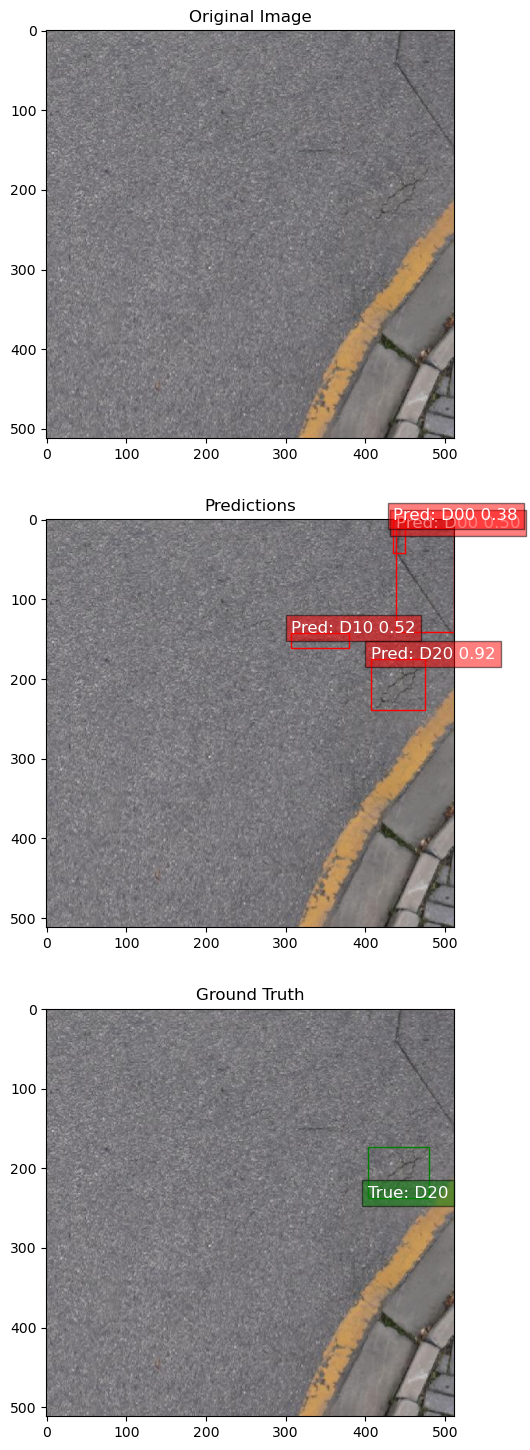

In [15]:
# Example usage
image_path = './Data/images/val/China_Drone_000086.jpg'
label_path = './Data/xmls/val/China_Drone_000086.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


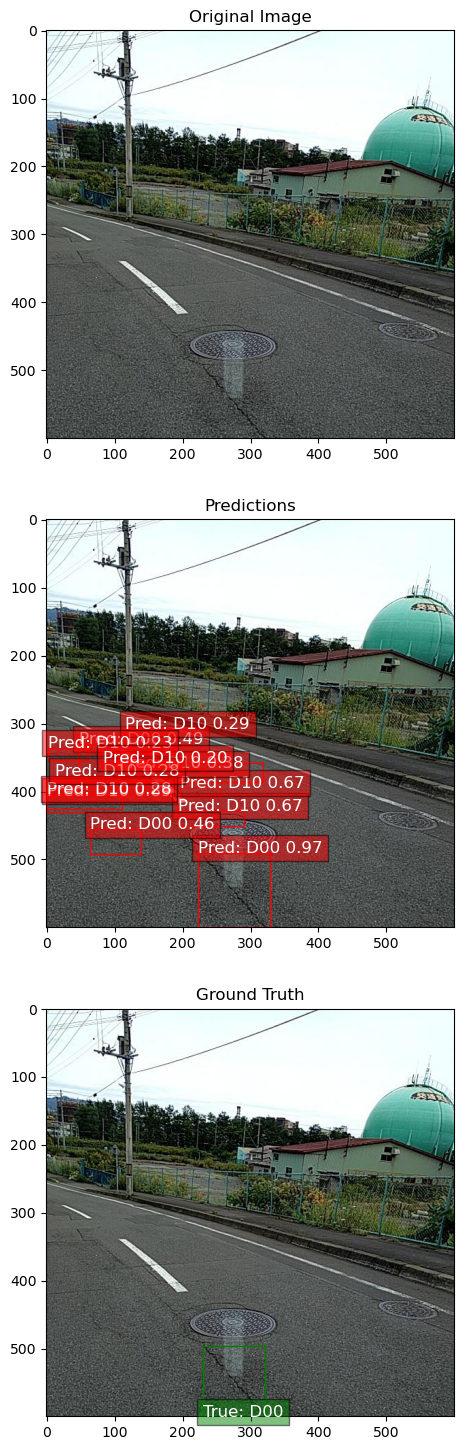

In [16]:
# Example usage
image_path = './Data/images/val/Japan_003127.jpg'
label_path = './Data/xmls/val/Japan_003127.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


In [20]:
import os
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from PIL import Image
local_model_path = f'./faster_rcnn_lr{lr}_bs{train_batch_size}_epochs{num_epochs}_mAP{best_mAP50}_stable.pth'
test_image_dir = os.path.join(image_dir, 'test')
test_label_dir = os.path.join(label_dir, 'test')
model_path = local_model_path
test_batch_size = 4

class TestDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = list(sorted(os.listdir(image_dir)))
        self.labels = list(sorted(os.listdir(label_dir)))
        self.class_to_idx = {'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}  # Update as necessary

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.labels[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.iter('object'):
            cls = obj.findtext('name')
            labels.append(self.class_to_idx[cls])
            xmlbox = obj.find('bndbox')
            boxes.append([int(xmlbox.findtext(tag)) for tag in ['xmin', 'ymin', 'xmax', 'ymax']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.nelement() != 0 else torch.zeros(0, dtype=torch.float32)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx]), 'area': area, 'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)}

        if self.transforms:
            img = self.transforms(img)

        return img, target

def get_transform():
    def transform(img):
        return F.to_tensor(img)
    return transform

# Load the model
def load_model(model_path, num_classes):
    model = get_model(num_classes)  # Ensure get_model is defined or imported
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

test_dataset = TestDataset(test_image_dir, test_label_dir, transforms=get_transform())
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

model = load_model(model_path, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mean_ap, precision, recall, f1_score = evaluate_or_test_model(model, test_loader, device)
print(f'Test mAP50: {mean_ap:.4f}')
print(f'F1 per group: {f1_score}, Recall per group: {recall}, Precision per group: {precision}')
print(f'General F1: {sum(f1_score) / len(f1_score)}, General Recall: {sum(recall) / len(recall)}, General Precision: {sum(precision) / len(precision)}')


Test mAP50: 0.5490
F1 per group: [0.43046207 0.38394433 0.50563043 0.3387467 ], Recall per group: [0.69315789 0.6925816  0.69796954 0.61798942], Precision per group: [0.31215928 0.26558944 0.3963964  0.23332002]
General F1: 0.414695880345538, General Recall: 0.6754246141392717, General Precision: 0.30186628290986983
